<a href="https://colab.research.google.com/github/AakankshaDahiya/Big-Data-Assignment/blob/main/plantdocfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Installing the required packages
!pip install tensorflow tqdm scikit-learn matplotlib --quiet

# STEP 2: Importing all the necessary libraries
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from google.colab import drive

# Check for GPU
print("✅ Available devices:", tf.config.list_physical_devices('GPU'))

✅ Available devices: []


In [ ]:
# STEP 3: Mounting Google Drive and defining the paths
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab Notebooks/CVAI/plantdoc.zip'
extracted_path_drive = '/content/plantdoc_data_drive'
extracted_path_local = '/content/plantdoc_data_local'

# Unzip only if not already done
if not os.path.exists(extracted_path_drive):
    os.makedirs(extracted_path_drive, exist_ok=True)
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path_drive)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='plantdoc.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('plantdoc.zip')
f.keys()
!unzip 'plantdoc.zip'

Archive:  plantdoc.zip
  inflating: file_renamer.py         
  inflating: folder_renamer.py       
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_1.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_10.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_2.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_3.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_4.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_5.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_6.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_7.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_8.jpg  
  inflating: test/Apple_Scab_Leaf/test_Apple Scab Leaf_9.jpg  
  inflating: test/Apple_leaf/test_Apple leaf_1.jpg  
  inflating: test/Apple_leaf/test_Apple leaf_2.jpg  
  inflating: test/Apple_leaf/test_Apple leaf_3.jpg  
  inflating: test/Apple_leaf/test_Apple leaf_4.jpg  
  inflating: test/Apple_leaf/test_Apple leaf_5.jpg  
  inf

In [ ]:
# Copy to local path for faster access
if not os.path.exists(extracted_path_local):
    shutil.copytree(extracted_path_drive, extracted_path_local)

dataset_path = extracted_path_local
image_size = 128
input_shape = (image_size, image_size, 3)
batch_size = 64

In [ ]:
# 🧹 STEP 3.5: Clean dataset and auto-detect classes
for item in os.listdir(dataset_path):
    full_path = os.path.join(dataset_path, item)
    # Remove files or empty folders
    if os.path.isfile(full_path):
        print(f"🧹 Removing file: {item}")
        os.remove(full_path)
    elif os.path.isdir(full_path) and len(os.listdir(full_path)) == 0:
        print(f"🧹 Removing empty folder: {item}")
        shutil.rmtree(full_path)

class_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
num_classes = len(class_folders)
print(f"✅ Number of classes: {num_classes}")
print(f"Classes: {class_folders}")

🧹 Removing file: file_renamer.py
🧹 Removing file: folder_renamer.py
✅ Number of classes: 2
Classes: ['train', 'test']



📸 Displaying sample leaf images from 'train' set:


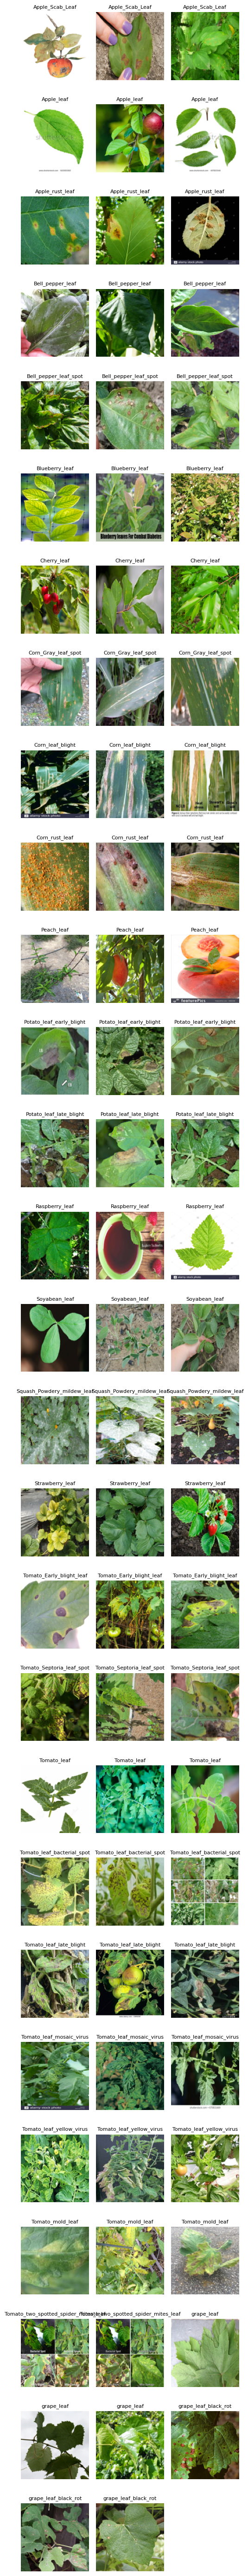

In [ ]:
# STEP 3.6: Display sample images from train folder
import random

def show_sample_images_from_subfolders(root_dir, subset='train', samples_per_class=3):
    base_path = os.path.join(root_dir, subset)
    class_names = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

    print(f"\n📸 Displaying sample leaf images from '{subset}' set:")
    plt.figure(figsize=(5, len(class_names) * 2))

    i = 1
    for class_name in class_names:
        class_dir = os.path.join(base_path, class_name)
        image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        if not image_files:
            continue
        sample_files = random.sample(image_files, min(samples_per_class, len(image_files)))
        for file in sample_files:
            img_path = os.path.join(class_dir, file)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((image_size, image_size))
                plt.subplot(len(class_names), samples_per_class, i)
                plt.imshow(img)
                plt.axis('off')
                plt.title(class_name, fontsize=8)
                i += 1
            except Exception as e:
                print(f"❌ Could not load {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Run the function on the train folder
show_sample_images_from_subfolders(dataset_path, subset='train', samples_per_class=3)


In [ ]:
# STEP 4: Create train and validation generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2338 images belonging to 2 classes.
Found 584 images belonging to 2 classes.


In [ ]:
# STEP 5: Build your CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# STEP 6: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# STEP 7: Train the model
epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8864 - loss: 0.4691 - val_accuracy: 0.9144 - val_loss: 0.2926
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9184 - loss: 0.2850 - val_accuracy: 0.9144 - val_loss: 0.2953
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9131 - loss: 0.2950 - val_accuracy: 0.9144 - val_loss: 0.2739
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.9111 - loss: 0.3042 - val_accuracy: 0.9144 - val_loss: 0.2858
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.9169 - loss: 0.2726 - val_accuracy: 0.9127 - val_loss: 0.2935
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9133 - loss: 0.2807 - val_accuracy: 0.9144 - val_loss: 0.2982
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9185 - loss: 0.2731 - val_accuracy: 0.9144 - val_loss: 0.2766
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.9138 - loss: 0.2595 - val_accuracy: 0.9058 - v

In [ ]:
# Save the model
model.save('custom_model1.h5')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,549,640 (74.58 MB)

 Trainable params: 6,516,546 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,033,094 (49.72 MB)

In [ ]:
# STEP 8: Evaluate model
loss, acc = model.evaluate(val_generator, verbose=0)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")


✅ Validation Accuracy: 88.01%


In [ ]:
# STEP 9: Classification report
val_generator.reset()
preds = model.predict(val_generator, verbose=0)
y_pred = preds.argmax(axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

        test       0.25      0.20      0.22        50
       train       0.93      0.94      0.94       534

    accuracy                           0.88       584
   macro avg       0.59      0.57      0.58       584
weighted avg       0.87      0.88      0.87       584



In [ ]:
# STEP 10: Save model
model.save('/content/plantdoc_cnn_model.h5')
print("✅ Model saved as plantdoc_cnn_model.h5")

✅ Model saved as plantdoc_cnn_model.h5


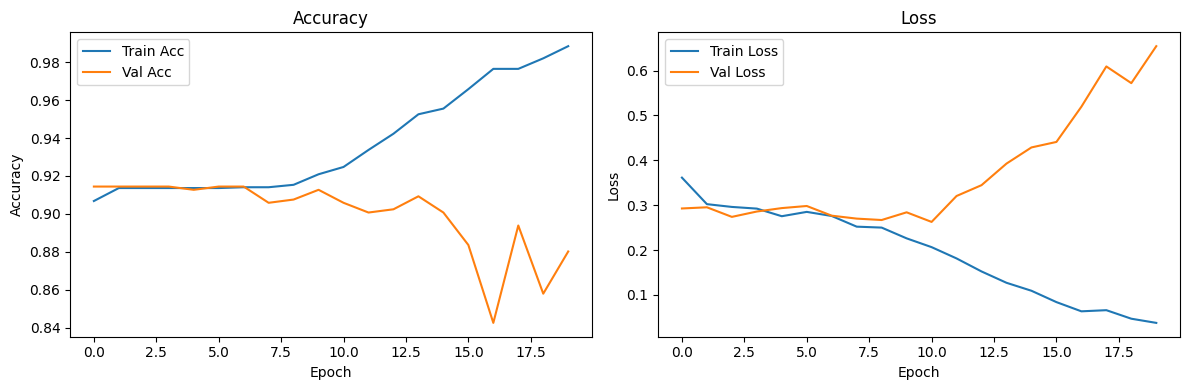

In [ ]:
# STEP 11: Plot accuracy/loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

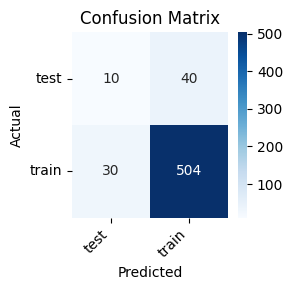

In [ ]:
# Generating Confussion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# STEP 9.5: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
